In [1]:
from pathlib import Path
import sys 

In [2]:
root_path = Path.cwd().parent 
if str(root_path) not in sys.path:
    sys.path.append(str(root_path))
root_path

PosixPath('/home/arpola/Documents/GalaxyClassifier')

In [3]:
from src.utils.general import get_data, LazyGalaxyDataset
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import pickle 
from scipy.ndimage import binary_dilation
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, center_of_mass
from scipy.optimize import minimize
import cv2


np.random.seed(42)
torch.manual_seed(42)

/home/arpola/Documents/GalaxyClassifier/.venv/lib/python3.12/site-packages/astroNN/__init__.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution
2025-08-03 08:46:22.159480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754221582.170862  157482 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754221582.174479  157482 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754221582.184386  157482 computation_pl

In [4]:
images, labels = get_data(cleaned=False)


No cleaned images found, please pre process them. Downloading normal images instead.


In [5]:
def split_data_indices(images,labels, root_path, save=True):
    images_path = root_path / 'data' / 'images.npy'
    labels_path = root_path / 'data' / 'labels.npy'
    original_indices = np.arange(len(images))

    #split
    train_indices,_indices = train_test_split(original_indices, test_size=0.4, stratify=labels, random_state=42)
    valid_indices,test_indices = train_test_split(_indices,test_size=0.5, stratify=labels[_indices], random_state=42)
    
    assert len(set(train_indices).intersection(set(_indices))) == 0, "Train and _indices indices overlap!"
    assert len(set(valid_indices).intersection(set(test_indices))) == 0, "Test and validation indices overlap!"

    del original_indices
    del _indices

    # Save
    if save:
        train_indice_path = root_path / 'data' / 'train_indices.npy'
        valid_indice_path = root_path / 'data' / 'valid_indices.npy'
        test_indice_path = root_path / 'data' / 'test_indices.npy'

        np.save(train_indice_path, train_indices)
        np.save(valid_indice_path, valid_indices)
        np.save(test_indice_path, test_indices)

    return train_indices,valid_indices,test_indices

In [6]:
_,_,_ = split_data_indices(images,labels,root_path, save=True)

In [7]:
from scipy.ndimage import binary_dilation, label, gaussian_filter
from skimage.morphology import remove_small_objects
import numpy as np

def simple_star_removal(image, percentile_threshold=97.0, min_star_size=2, max_star_size=100):
    """Remove stars while preserving galaxy centers"""
    
    # Handle different input shapes
    if len(image.shape) == 3:  # (C, H, W)
        if image.shape[0] == 3:  # RGB
            gray = 0.299*image[0] + 0.587*image[1] + 0.114*image[2]
        else:
            gray = image[0]
    else:  # (H, W)
        gray = image
    
    # Find bright pixels
    threshold = np.percentile(gray, percentile_threshold)
    bright_mask = gray > threshold
    
    # Remove small noise first
    bright_mask = remove_small_objects(bright_mask, min_size=min_star_size)
    
    # Label connected components
    labeled_objects, num_objects = label(bright_mask)
    
    # Identify stars vs galaxy components
    star_mask = np.zeros_like(bright_mask)
    
    for obj_id in range(1, num_objects + 1):
        obj_mask = labeled_objects == obj_id
        
        # Calculate object properties
        obj_size = np.sum(obj_mask)
        
        # Get bounding box
        y_coords, x_coords = np.where(obj_mask)
        if len(y_coords) == 0:
            continue
            
        y_min, y_max = y_coords.min(), y_coords.max()
        x_min, x_max = x_coords.min(), x_coords.max()
        
        # Calculate aspect ratio and compactness
        width = x_max - x_min + 1
        height = y_max - y_min + 1
        aspect_ratio = max(width, height) / min(width, height)
        
        # Calculate circularity (4π*area/perimeter²)
        perimeter = np.sum(binary_dilation(obj_mask) ^ obj_mask)
        if perimeter > 0:
            circularity = 4 * np.pi * obj_size / (perimeter ** 2)
        else:
            circularity = 0
        
        # Stars are typically:
        # - Small and compact
        # - Roughly circular (low aspect ratio)
        # - Not at image center (galaxies usually centered)
        center_y, center_x = gray.shape[0] // 2, gray.shape[1] // 2
        obj_center_y, obj_center_x = np.mean(y_coords), np.mean(x_coords)
        distance_from_center = np.sqrt((obj_center_y - center_y)**2 + 
                                     (obj_center_x - center_x)**2)
        
        # Classify as star if:
        is_star = (
            obj_size < max_star_size and  # Small
            aspect_ratio < 2.0 and       # Roughly circular
            circularity > 0.3 and        # Compact
            distance_from_center > min(gray.shape) * 0.1  # Not at center
        )
        
        if is_star:
            star_mask |= obj_mask
    
    # Dilate star mask slightly to cover halos
    star_mask = binary_dilation(star_mask, iterations=2)
    
    # Replace masked pixels
    cleaned_image = image.copy()
    if len(image.shape) == 3:
        for c in range(image.shape[0]):
            cleaned_image[c][star_mask] = np.median(image[c][~star_mask])
    else:
        cleaned_image[star_mask] = np.median(image[~star_mask])
    
    return cleaned_image, star_mask

(3, 256, 256)


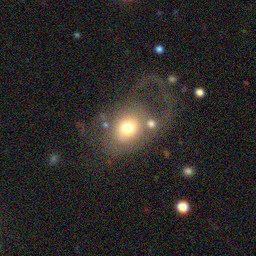

In [12]:
img_example = images[333]
img_transposed = np.transpose(img_example, (2,0,1))
print(img_transposed.shape)
Image.fromarray(img_transposed.transpose(1,2,0))

(3, 256, 256)


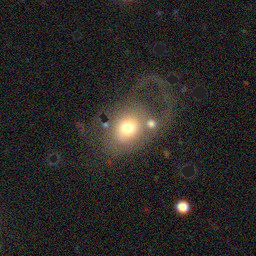

In [13]:
print(img_transposed.shape)
cleaned,mask = simple_star_removal(img_transposed)
Image.fromarray(cleaned.transpose(1,2,0))

In [130]:
if len(cleaned.shape) == 3:  # Multi-channel
    rotated = np.rot90(cleaned, 2, axes=(-2, -1))
else:  # Single channel
    rotated = np.rot90(cleaned, 2)
        
# Asymmetry calculation
residual = np.abs(cleaned - rotated)
asymmetry = np.sum(residual) / np.sum(np.abs(cleaned))
asymmetry

np.float64(3.1939836797640893)

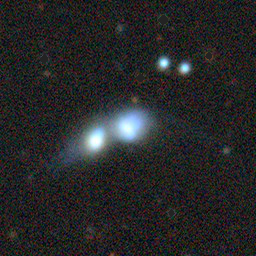

In [131]:
Image.fromarray(rotated.transpose(1,2,0))

In [93]:


def find_galaxy_center(image, method='centroid'):
    """
    Find galaxy center (equivalent to IRAF imcntr)
    """
    if len(image.shape) == 3:
        gray = image[0] if image.shape[0] == 1 else np.mean(image, axis=0)
    else:
        gray = image
    
    if method == 'centroid':
        # Weighted centroid (similar to imcntr)
        y_coords, x_coords = np.mgrid[:gray.shape[0], :gray.shape[1]]
        total_intensity = np.sum(gray)
        
        if total_intensity > 0:
            center_y = np.sum(y_coords * gray) / total_intensity
            center_x = np.sum(x_coords * gray) / total_intensity
        else:
            center_y, center_x = gray.shape[0]//2, gray.shape[1]//2
            
    elif method == 'brightest':
        # Find brightest pixel near center
        h, w = gray.shape
        center_region = gray[h//4:3*h//4, w//4:3*w//4]
        brightest = np.unravel_index(np.argmax(center_region), center_region.shape)
        center_y = brightest[0] + h//4
        center_x = brightest[1] + w//4
    
    return center_y, center_x

def rotate_image_about_center(image, angle, center):
    """
    Rotate image about specified center point
    """
    center_y, center_x = center
    h, w = image.shape[-2:]
    
    # Create rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((center_x, center_y), angle, 1.0)
    
    if len(image.shape) == 3:
        rotated = np.zeros_like(image)
        for c in range(image.shape[0]):
            rotated[c] = cv2.warpAffine(image[c], rotation_matrix, (w, h), 
                                      flags=cv2.INTER_LINEAR, 
                                      borderMode=cv2.BORDER_REFLECT)
    else:
        rotated = cv2.warpAffine(image, rotation_matrix, (w, h), 
                               flags=cv2.INTER_LINEAR, 
                               borderMode=cv2.BORDER_REFLECT)
    
    return rotated

def create_galaxy_mask(image, center, method='adaptive'):
    """
    Create mask for galaxy region (where to compute asymmetry)
    """
    if len(image.shape) == 3:
        gray = image[0] if image.shape[0] == 1 else np.mean(image, axis=0)
    else:
        gray = image
    
    center_y, center_x = center
    h, w = gray.shape
    
    if method == 'adaptive':
        # Create distance map from center
        y_coords, x_coords = np.mgrid[:h, :w]
        distances = np.sqrt((y_coords - center_y)**2 + (x_coords - center_x)**2)
        
        # Find radius that contains significant galaxy light
        # Use Petrosian-like approach
        max_radius = min(h, w) // 3
        radii = np.arange(1, max_radius, 2)
        
        intensities = []
        for r in radii:
            mask = distances <= r
            if np.sum(mask) > 0:
                mean_intensity = np.mean(gray[mask])
                intensities.append(mean_intensity)
            else:
                intensities.append(0)
        
        # Find where intensity drops significantly
        intensities = np.array(intensities)
        if len(intensities) > 5:
            # Find radius where intensity is 20% of peak
            peak_intensity = np.max(intensities)
            threshold = 0.2 * peak_intensity
            
            valid_indices = intensities > threshold
            if np.any(valid_indices):
                galaxy_radius = radii[np.where(valid_indices)[0][-1]]
            else:
                galaxy_radius = max_radius // 2
        else:
            galaxy_radius = max_radius // 2
        
        # Create circular mask
        mask = distances <= galaxy_radius
        
    elif method == 'fixed_fraction':
        # Use fixed fraction of image size
        galaxy_radius = min(h, w) * 0.3
        y_coords, x_coords = np.mgrid[:h, :w]
        distances = np.sqrt((y_coords - center_y)**2 + (x_coords - center_x)**2)
        mask = distances <= galaxy_radius
    
    return mask

def conselice_asymmetry(image, star_removed=True):
    """
    Calculate Conselice asymmetry parameter following the exact method
    
    A² = Σ(Io - I180)² / (2 * ΣIo²)
    """
    
    # Step 1: Find galaxy center
    center_y, center_x = find_galaxy_center(image, method='centroid')
    
    # Step 2: Rotate image by 180° about its center
    rotated_image = rotate_image_about_center(image, 180, (center_y, center_x))
    
    # Step 3: Create residual map (original - rotated)
    residual = image - rotated_image
    
    # Step 4: Create galaxy mask (area to sum over)
    galaxy_mask = create_galaxy_mask(image, (center_y, center_x))
    
    # Step 5: Calculate asymmetry following Conselice formula
    if len(image.shape) == 3:
        # Multi-channel case
        asymmetries = []
        for c in range(image.shape[0]):
            residual_squared = residual[c]**2
            original_squared = image[c]**2
            
            # Sum over galaxy region
            numerator = np.sum(residual_squared[galaxy_mask])
            denominator = 2 * np.sum(original_squared[galaxy_mask])
            
            if denominator > 0:
                asymmetry_squared = numerator / denominator
                asymmetry = np.sqrt(asymmetry_squared)  
            else:
                asymmetry = 0
                
            asymmetries.append(asymmetry)
        
        return np.mean(asymmetries), (center_y, center_x), galaxy_mask
    
    else:
        # Single channel case
        residual_squared = residual**2
        original_squared = image**2
        
        # Sum over galaxy region
        numerator = np.sum(residual_squared[galaxy_mask])
        denominator = 2 * np.sum(original_squared[galaxy_mask])
        
        if denominator > 0:
            asymmetry_squared = numerator / denominator
            asymmetry = np.sqrt(asymmetry_squared)
        else:
            asymmetry = 0
        
        return asymmetry, (center_y, center_x), galaxy_mask

def visualize_asymmetry_calculation(image, asymmetry, center, mask):
    """Visualize the asymmetry calculation process"""
    
    if len(image.shape) == 3:
        display_image = image[0]
    else:
        display_image = image
    
    # Create rotated image
    rotated = rotate_image_about_center(image, 180, center)
    if len(rotated.shape) == 3:
        rotated_display = rotated[0]
    else:
        rotated_display = rotated
    
    # Create residual
    residual = display_image - rotated_display
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original with center and mask
    axes[0, 0].imshow(display_image, cmap='gray')
    axes[0, 0].plot(center[1], center[0], 'r+', markersize=10, markeredgewidth=2)
    axes[0, 0].contour(mask, levels=[0.5], colors='red', linewidths=1)
    axes[0, 0].set_title('Original + Center + Galaxy Mask')
    axes[0, 0].axis('off')
    
    # Rotated
    axes[0, 1].imshow(rotated_display, cmap='gray')
    axes[0, 1].set_title('180° Rotated')
    axes[0, 1].axis('off')
    
    # Residual
    im = axes[1, 0].imshow(residual, cmap='RdBu_r', vmin=-np.std(residual)*3, vmax=np.std(residual)*3)
    axes[1, 0].contour(mask, levels=[0.5], colors='black', linewidths=1)
    axes[1, 0].set_title(f'Residual (Original - Rotated)')
    axes[1, 0].axis('off')
    plt.colorbar(im, ax=axes[1, 0])
    
    # Residual squared in galaxy region
    residual_squared = residual**2
    masked_residual = np.where(mask, residual_squared, 0)
    axes[1, 1].imshow(masked_residual, cmap='hot')
    axes[1, 1].set_title(f'Residual² in Galaxy Region\nAsymmetry = {asymmetry:.4f}')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

Image 0: Asymmetry = 0.6127


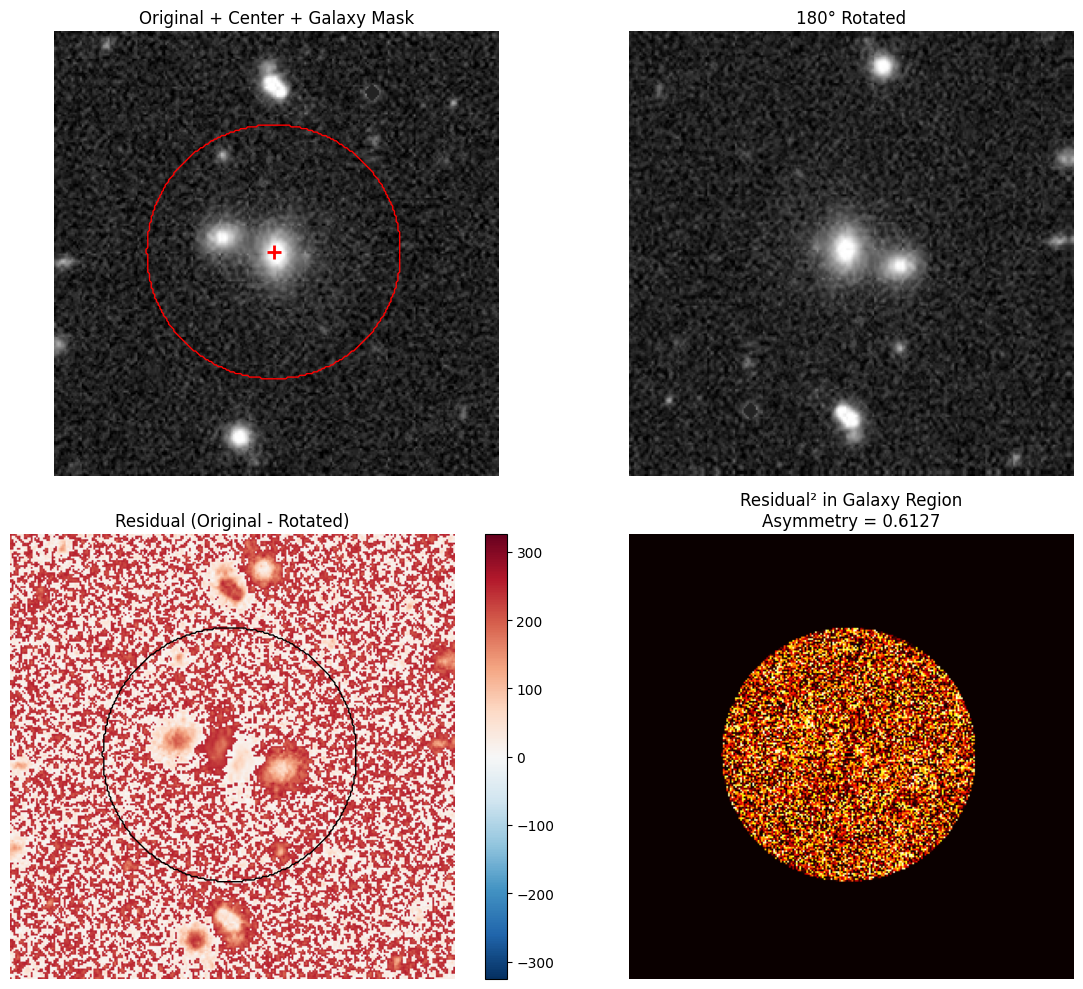

Image 1: Asymmetry = 0.5971


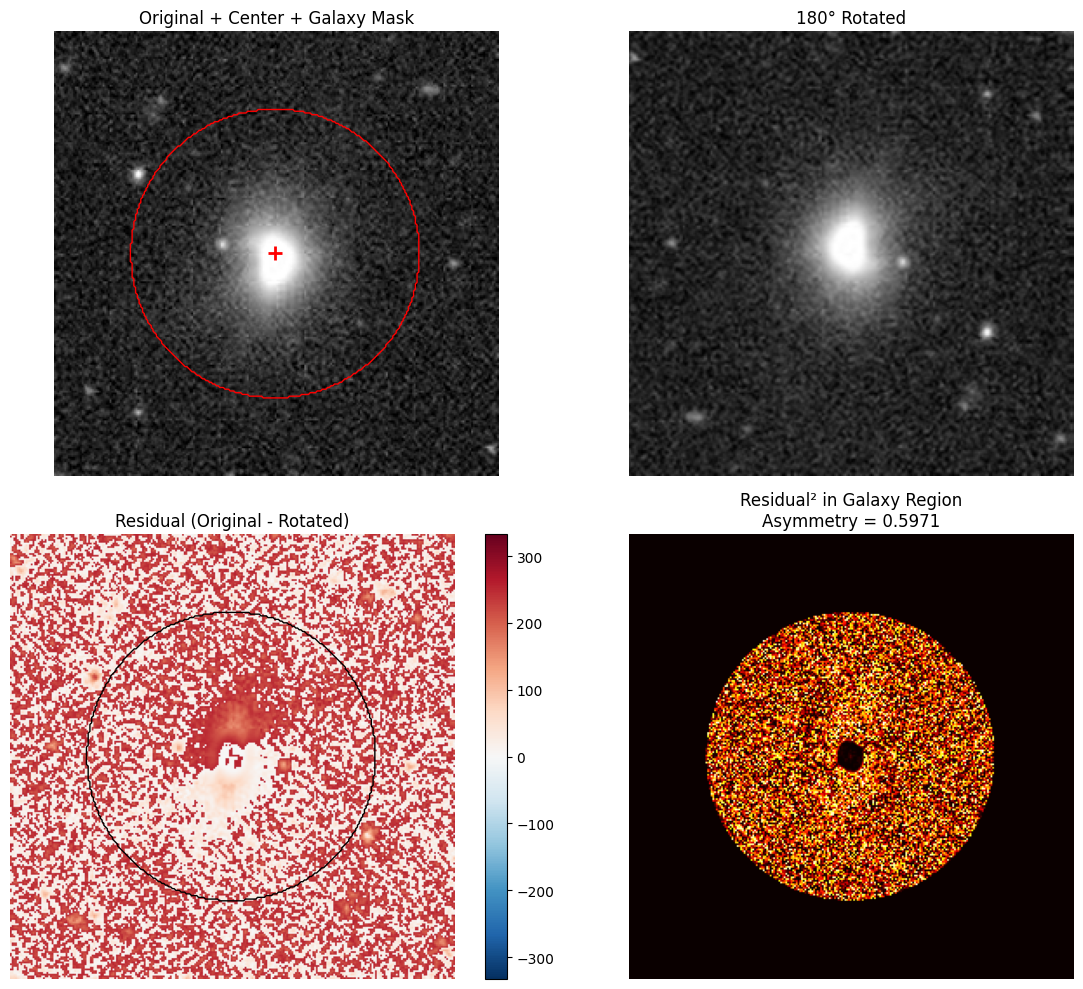

Image 2: Asymmetry = 0.6099


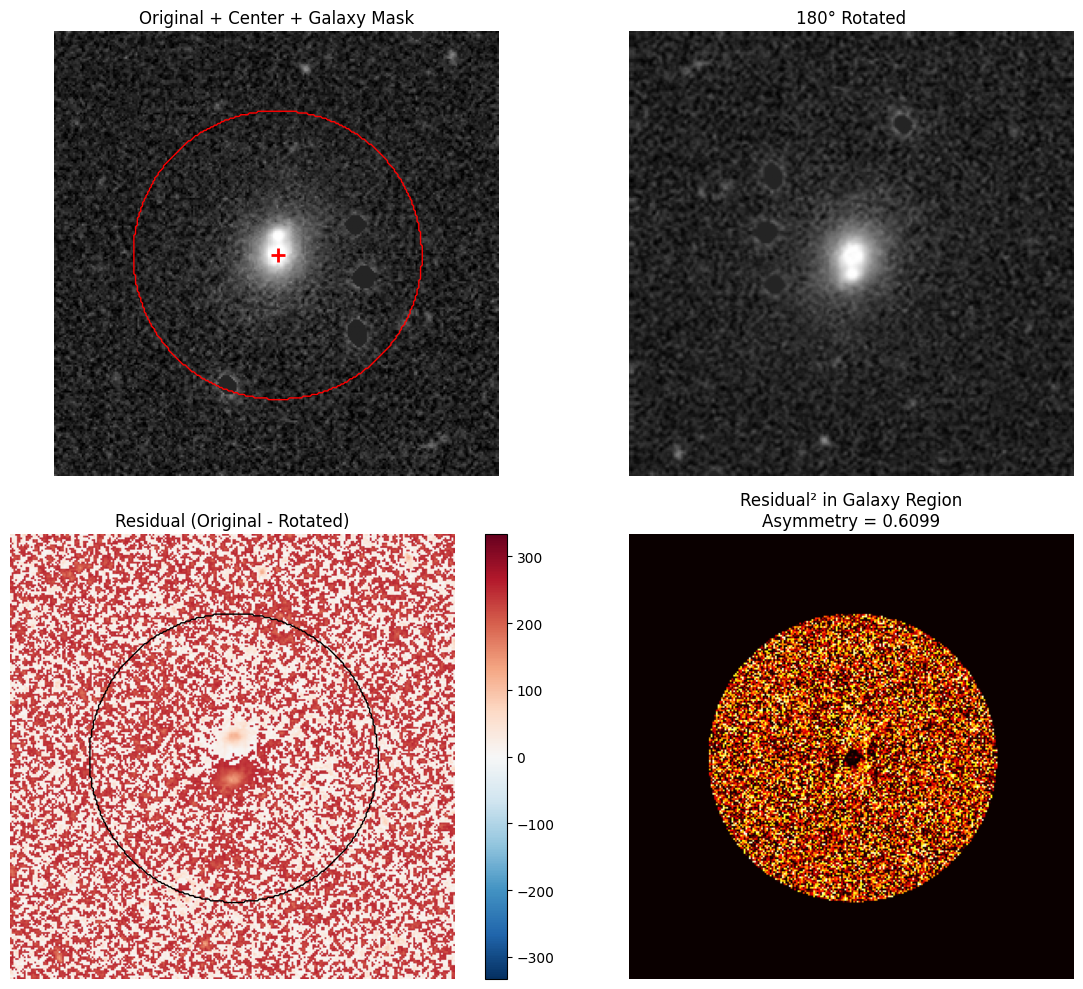

Image 3: Asymmetry = 0.6136


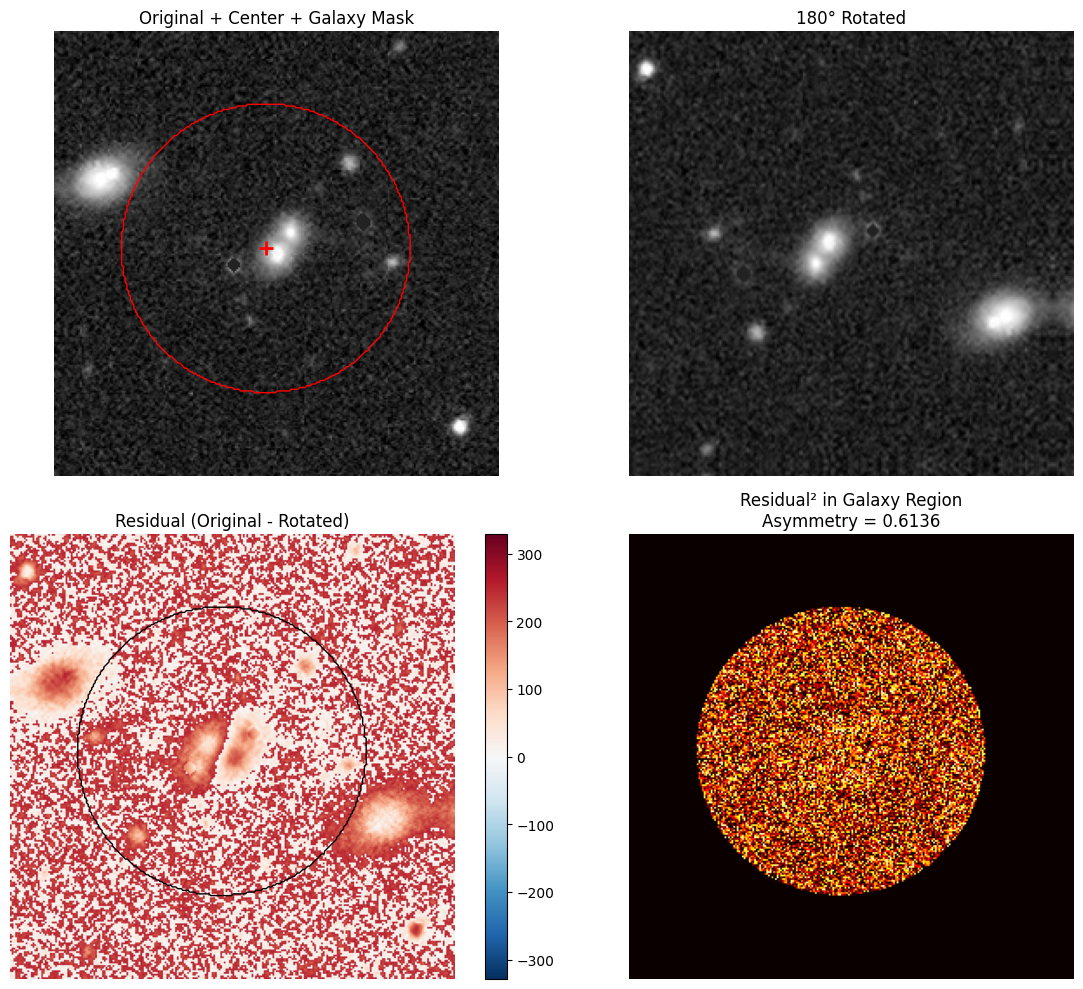

Image 4: Asymmetry = 0.6684


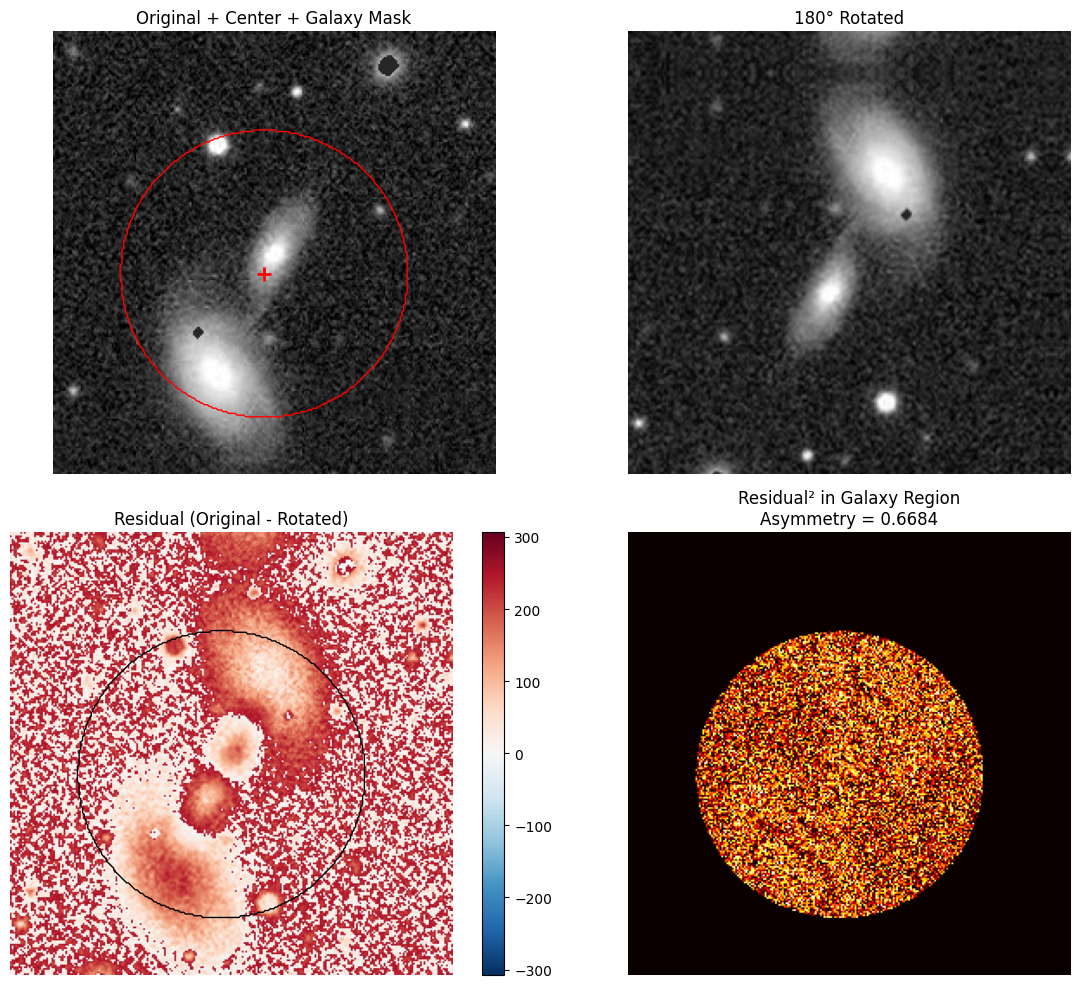

In [105]:
# Test on a few images
def test_conselice_asymmetry(images, n_samples=5):
    """Test the asymmetry calculation"""
    
    for i in range(min(n_samples, len(images))):
        # Remove stars first
        img_transposed = np.transpose(images[i], (2,0,1))
        cleaned_image, _ = simple_star_removal(img_transposed)
        
        # Calculate asymmetry
        asymmetry, center, mask = conselice_asymmetry(cleaned_image)
        
        print(f"Image {i}: Asymmetry = {asymmetry:.4f}")
        
        # Visualize
        visualize_asymmetry_calculation(cleaned_image, asymmetry, center, mask)

# Run on your dataset
spirals = labels
test_conselice_asymmetry(images[1300:1324])